# Library

In [1]:
!pip install torchsummary

In [2]:
import os
import torch
import random
import torch.nn as nn
from PIL import Image
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision.datasets import ImageFolder

# Visualize Patches

In [3]:
# Setup dataset path
train_data_path = 'Dataset/Train'  # Update with your train dataset path

In [4]:
# Load train dataset using ImageFolder
train_data = ImageFolder(root=train_data_path)

In [5]:
# Randomly select an image from the dataset
random_idx = random.randint(0, len(train_data) - 1)
image_path, _ = train_data.samples[random_idx]

In [6]:
# Load the image
image = Image.open(image_path)

In [7]:
# Define the transform to resize the image to 224x224 (required for ViT)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [8]:
# Apply transform
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

## Display Original Image

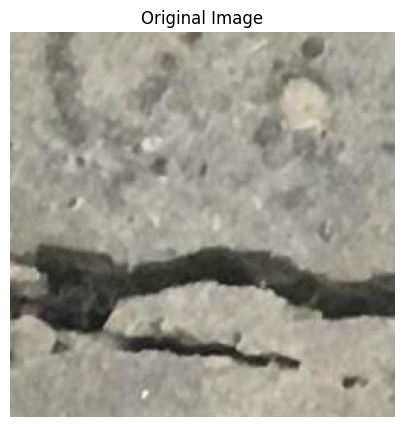

In [9]:
# Display the original image
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()

In [10]:
# Get image size
image_size = image_tensor.shape[2:]  # (Height, Width)
print(f"Image size (Height, Width): {image_size}")

Image size (Height, Width): torch.Size([224, 224])


## Display Patches Image

In [11]:
# Define patch size and number of patches for ViT
patch_size = 16
num_patches = (image_size[0] // patch_size) * (image_size[1] // patch_size)

print(f"Patch size: {patch_size}x{patch_size}")
print(f"Number of patches: {num_patches}")

Patch size: 16x16
Number of patches: 196


In [12]:
# Function to visualize patches
def visualize_patches(image_tensor, patch_size):
    # Convert the tensor to numpy for visualization
    image_np = image_tensor.squeeze().permute(1, 2, 0).numpy()

    # Create a figure to display patches
    fig, ax = plt.subplots(figsize=(5, 5))

    # Display the original resized image
    ax.imshow(image_np)

    # Draw patches on the image
    for i in range(0, image_np.shape[0], patch_size):
        for j in range(0, image_np.shape[1], patch_size):
            rect = plt.Rectangle((j, i), patch_size, patch_size, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    plt.title(f"Image with {num_patches} patches of size {patch_size}x{patch_size}")
    plt.axis('off')
    plt.show()

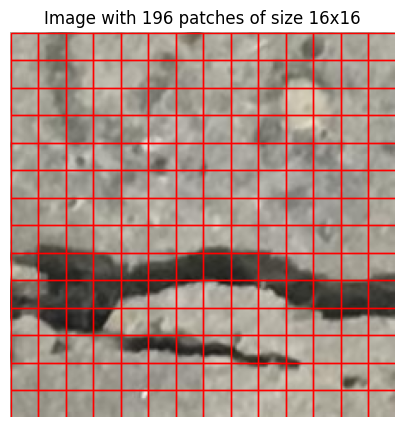

In [13]:
# Visualize the patches on the image
visualize_patches(image_tensor, patch_size)

# Modelling ViT

## Setup model & device

In [14]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the transform for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

## Load Dataset

In [15]:
# Load train and test datasets
train_data = datasets.ImageFolder(root='Dataset/Train', transform=transform)
test_data = datasets.ImageFolder(root='Dataset/Test', transform=transform)

In [16]:
# Dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## Load Model

In [17]:
# Load the ViT model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=2, ignore_mismatched_sizes=True)
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [18]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## Model Callbacks

In [19]:
# Add ReduceLROnPlateau callback
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [20]:
# Directory to save model checkpoints
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [21]:
# Function to save model checkpoint
def save_checkpoint(epoch, model, optimizer, loss, checkpoint_path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }, checkpoint_path)
    print(f"Model saved to {checkpoint_path}")

## Train Model

In [22]:
# Variables to store loss and accuracy history
train_losses = []
test_accuracies = []
best_loss = float('inf')

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_steps = len(train_loader)

    for step, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print step progress
        if (step + 1) %200 == 0:  # Print every 100 steps (adjust as needed)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{step + 1}/{total_steps}], Loss: {loss.item():.4f}")

    # Store training loss
    avg_loss = running_loss / total_steps
    train_losses.append(avg_loss)

    # Testing loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Store test accuracy
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Avg Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    # Save checkpoint if the loss improves
    if avg_loss < best_loss:
        best_loss = avg_loss
        checkpoint_path = os.path.join(checkpoint_dir, f"best_model_epoch_{epoch + 1}.pt")
        save_checkpoint(epoch + 1, model, optimizer, best_loss, checkpoint_path)

    # Reduce learning rate if no improvement
    scheduler.step(avg_loss)


c:\Users\hasan\anaconda3\envs\pytorch\lib\site-packages\transformers\models\vit\modeling_vit.py:252: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


Epoch [1/20], Step [200/1000], Loss: 0.0002
Epoch [1/20], Step [400/1000], Loss: 0.0001
Epoch [1/20], Step [600/1000], Loss: 0.0005
Epoch [1/20], Step [800/1000], Loss: 0.1266
Epoch [1/20], Step [1000/1000], Loss: 0.0002
Epoch [1/20], Avg Loss: 0.0118, Test Accuracy: 99.62%
Model saved to ./checkpoints\best_model_epoch_1.pt
Epoch [2/20], Step [200/1000], Loss: 0.0054
Epoch [2/20], Step [400/1000], Loss: 0.0016
Epoch [2/20], Step [600/1000], Loss: 0.0000
Epoch [2/20], Step [800/1000], Loss: 0.0077
Epoch [2/20], Step [1000/1000], Loss: 0.0000
Epoch [2/20], Avg Loss: 0.0045, Test Accuracy: 99.83%
Model saved to ./checkpoints\best_model_epoch_2.pt
Epoch [3/20], Step [200/1000], Loss: 0.0001
Epoch [3/20], Step [400/1000], Loss: 0.0000
Epoch [3/20], Step [600/1000], Loss: 0.0964
Epoch [3/20], Step [800/1000], Loss: 0.0000
Epoch [3/20], Step [1000/1000], Loss: 0.0005
Epoch [3/20], Avg Loss: 0.0045, Test Accuracy: 99.85%
Model saved to ./checkpoints\best_model_epoch_3.pt
Epoch [4/20], Step [20

## Plot Result

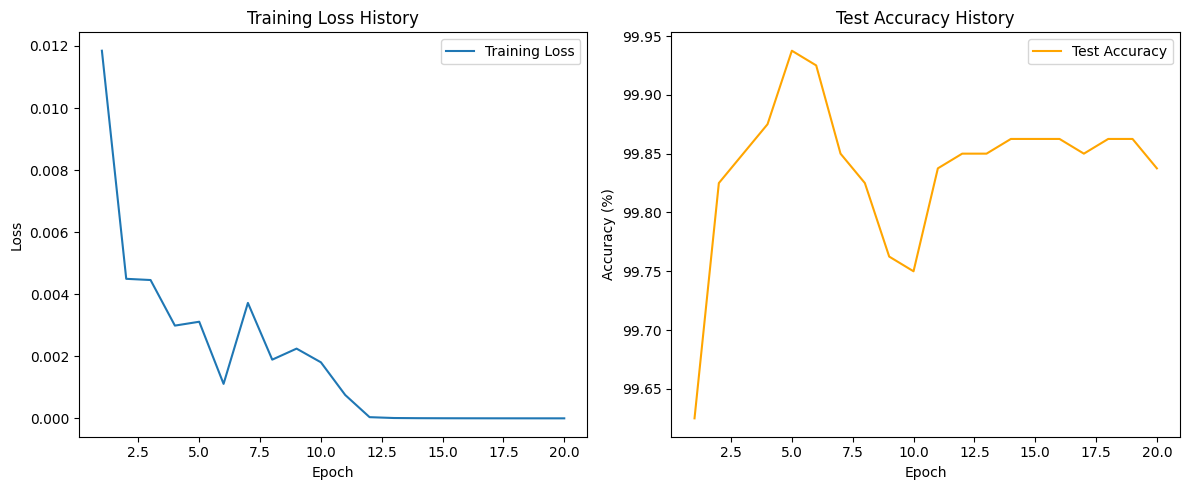

In [23]:
# Plotting loss and accuracy history
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy History')
plt.legend()

plt.tight_layout()
plt.show()